In [181]:
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix
# Load the dataset
file_path = 'Data_Tanaman_Padi_Indonesia_2018-2023_Erlin_New.csv'
data = pd.read_csv(file_path)
print("First few rows of the dataset:")
print(data.head())

First few rows of the dataset:
  Province  Year  Harvested Area  Production  Rainfall  Humidity  Temperature
0     Aceh  2018          329516     1861567      2336        81           28
1     Aceh  2019          310012     1714438      1437        82           27
2     Aceh  2020          317869     1757313      1790        76           29
3     Aceh  2021          297058     1634640      2293        76           29
4     Aceh  2022          271750     1509456      1834        76           29



Descriptive statistics:
              Year  Harvested Area    Production     Rainfall    Humidity  \
count   204.000000    2.040000e+02  2.040000e+02   204.000000  204.000000   
mean   2020.500000    3.126199e+05  1.623743e+06  2555.210784   80.230392   
std       1.712026    4.735449e+05  2.682466e+06   834.901557    3.966716   
min    2018.000000    1.390000e+02  4.230000e+02   490.000000   67.000000   
25%    2019.000000    5.226425e+04  2.300308e+05  2086.750000   78.000000   
50%    2020.500000    1.112275e+05  5.310985e+05  2555.000000   80.000000   
75%    2022.000000    3.126992e+05  1.560927e+06  2958.500000   83.000000   
max    2023.000000    1.821983e+06  1.049959e+07  5332.000000   91.000000   

       Temperature  
count   204.000000  
mean     27.921569  
std       0.953978  
min      25.000000  
25%      27.000000  
50%      28.000000  
75%      29.000000  
max      30.000000  


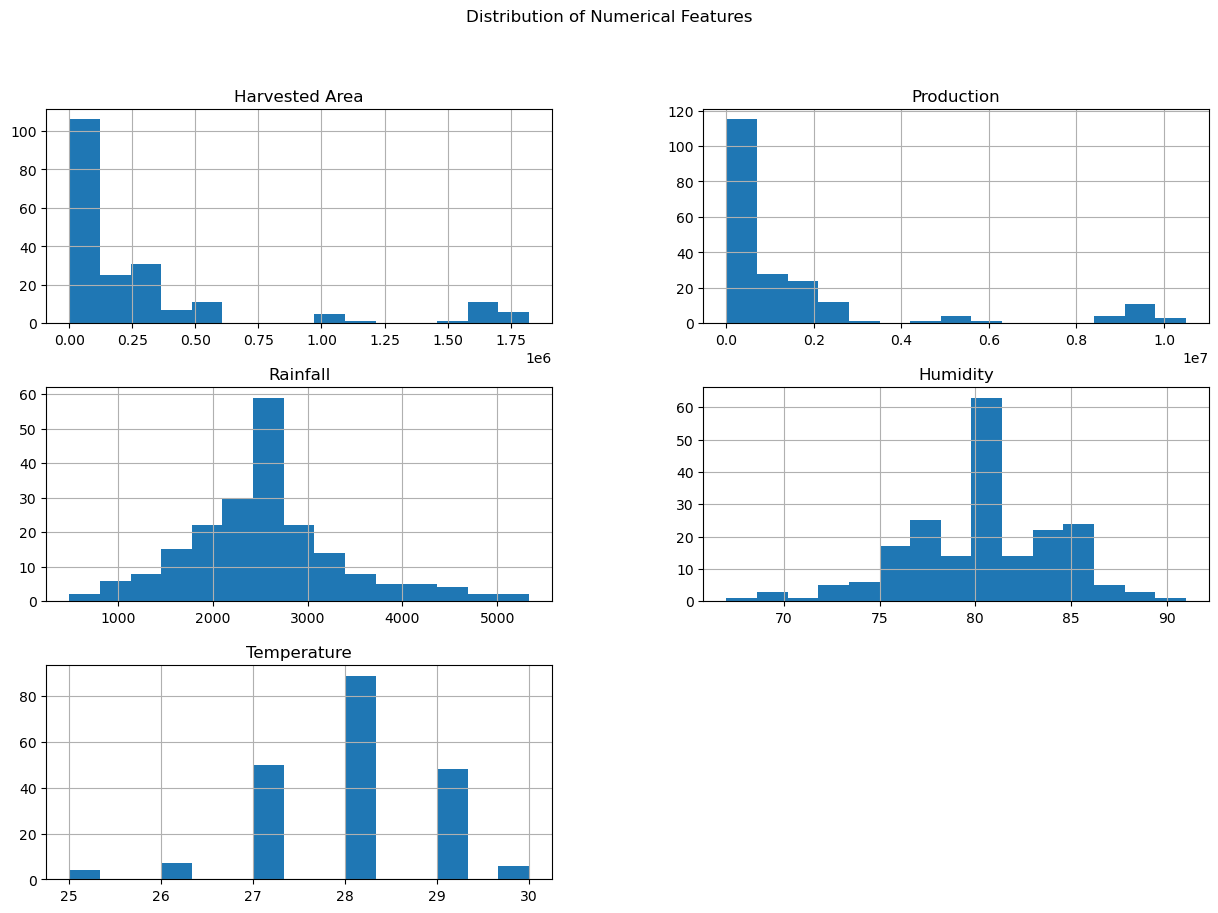

In [161]:
# Univariate Analysis: Descriptive statistics
print("\nDescriptive statistics:")
print(data.describe())

# Univariate Analysis: Distribution of numerical features
import matplotlib.pyplot as plt

numerical_features = ['Harvested Area', 'Production', 'Rainfall', 'Humidity', 'Temperature']
data[numerical_features].hist(bins=15, figsize=(15, 10), layout=(3, 2))
plt.suptitle('Distribution of Numerical Features')
plt.show()

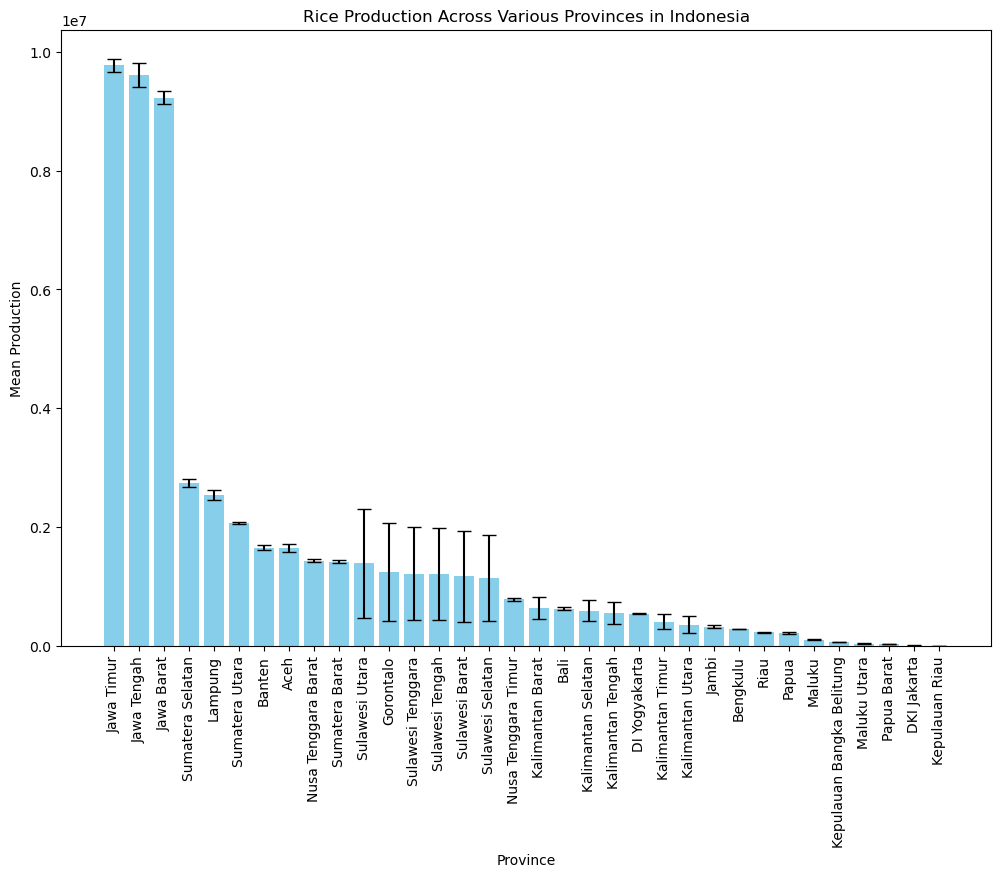

In [41]:
# Calculate mean and standard error of production for each province
province_stats = data.groupby('Province')['Production'].agg(['mean', 'sem']).sort_values(by='mean', ascending=False)
# Rice production across various provinces in Indonesia
# Plot rice production across various provinces with error bars
plt.figure(figsize=(12, 8))
plt.bar(province_stats.index, province_stats['mean'], yerr=province_stats['sem'], color='skyblue', capsize=5)
plt.title('Rice Production Across Various Provinces in Indonesia')
plt.xlabel('Province')
plt.ylabel('Mean Production')
plt.xticks(rotation=90)
plt.show()

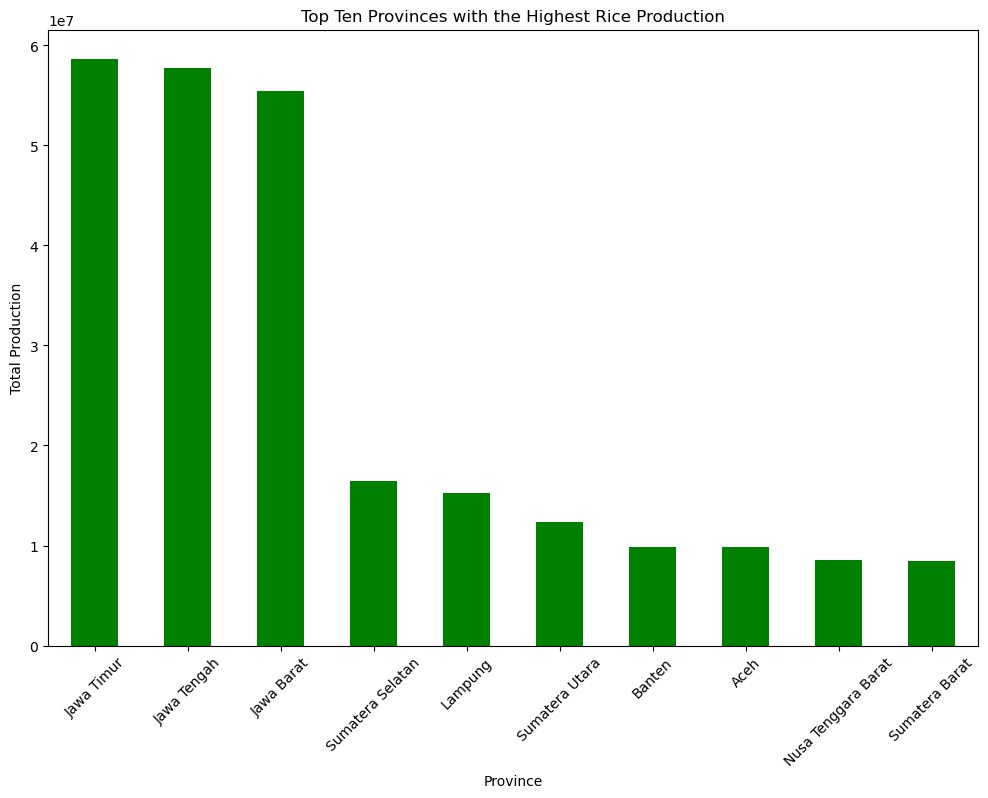

In [27]:
# Top ten provinces with the highest production
top_ten_provinces = province_production.head(10)
plt.figure(figsize=(12, 8))
top_ten_provinces.plot(kind='bar', color='green')
plt.title('Top Ten Provinces with the Highest Rice Production')
plt.xlabel('Province')
plt.ylabel('Total Production')
plt.xticks(rotation=45)
plt.show()

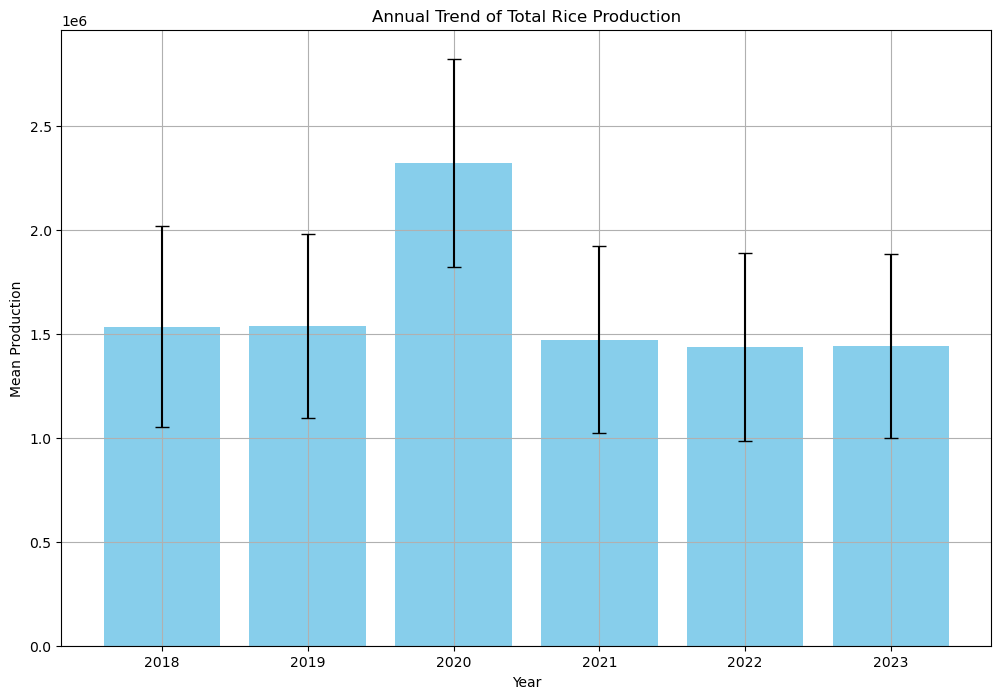

In [33]:
# Calculate mean and standard error of production for each year
annual_stats = data.groupby('Year')['Production'].agg(['mean', 'sem'])

# Plot annual trend of total rice production with error bars
plt.figure(figsize=(12, 8))
plt.bar(annual_stats.index, annual_stats['mean'], yerr=annual_stats['sem'], color='skyblue', capsize=5)
plt.title('Annual Trend of Total Rice Production')
plt.xlabel('Year')
plt.ylabel('Mean Production')
plt.grid(True)
plt.show()

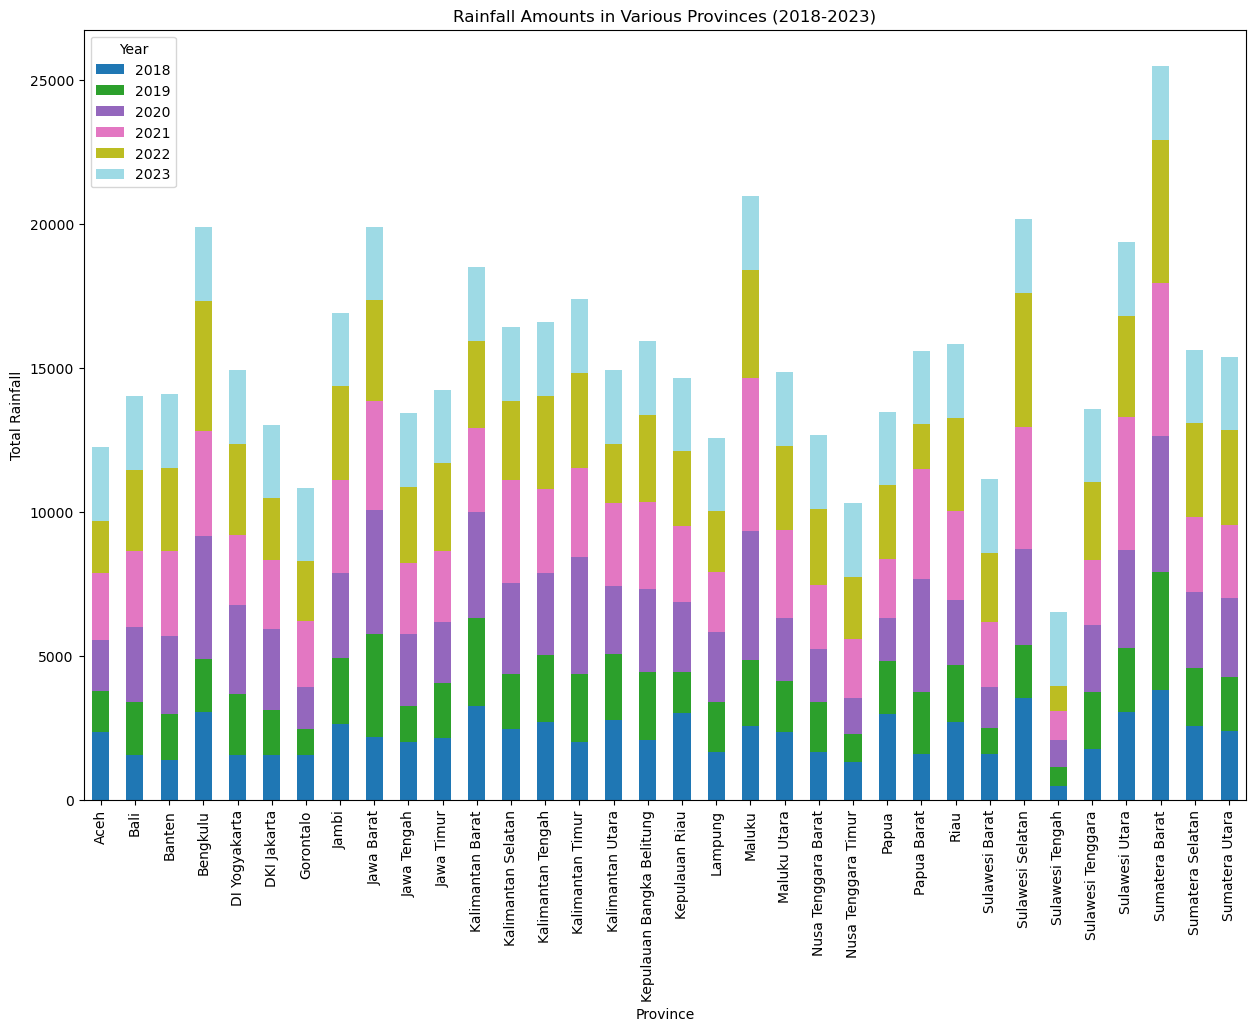

In [37]:
# Pivot the data to get years as columns and provinces as rows
pivot_data = data.pivot(index='Province', columns='Year', values='Rainfall')

# Plot stacked column chart
pivot_data.plot(kind='bar', stacked=True, figsize=(15, 10), colormap='tab20')
plt.title('Rainfall Amounts in Various Provinces (2018-2023)')
plt.xlabel('Province')
plt.ylabel('Total Rainfall')
plt.xticks(rotation=90)
plt.legend(title='Year')
plt.show()

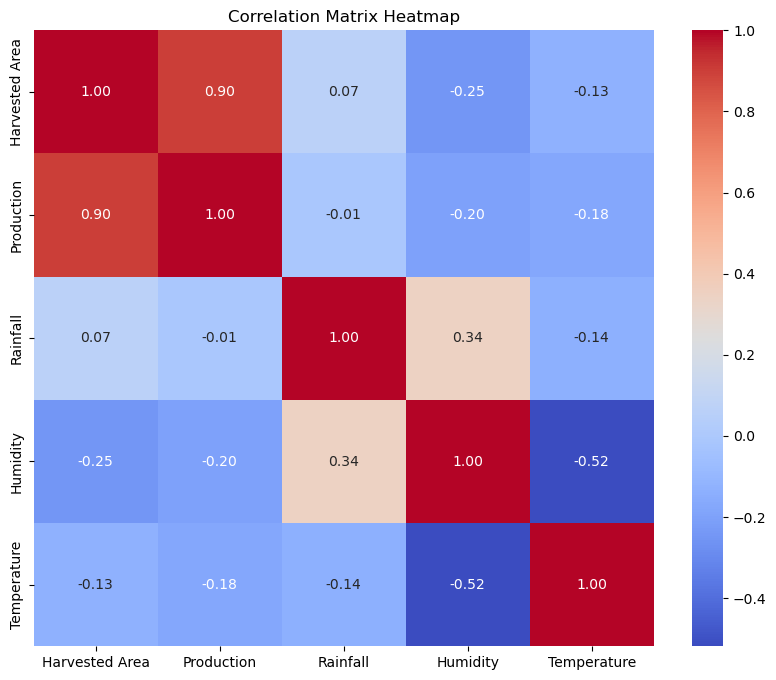


Pearson Correlation Coefficients:
                Harvested Area  Production  Rainfall  Humidity  Temperature
Harvested Area        1.000000    0.903459  0.065607 -0.250314    -0.131761
Production            0.903459    1.000000 -0.012981 -0.199966    -0.179358
Rainfall              0.065607   -0.012981  1.000000  0.344409    -0.136164
Humidity             -0.250314   -0.199966  0.344409  1.000000    -0.518513
Temperature          -0.131761   -0.179358 -0.136164 -0.518513     1.000000


In [43]:
# Select only the numerical features for correlation analysis
numerical_features = ['Harvested Area', 'Production', 'Rainfall', 'Humidity', 'Temperature']

# Bivariate Analysis: Correlation matrix
correlation_matrix = data[numerical_features].corr(method='pearson')
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.show()

# Print the correlation matrix
print("\nPearson Correlation Coefficients:")
print(correlation_matrix)

In [45]:
# Check for missing values in the dataset
missing_values = data.isnull().sum()
print("\nMissing values in each column:")
print(missing_values)


Missing values in each column:
Province          0
Year              0
Harvested Area    0
Production        0
Rainfall          0
Humidity          0
Temperature       0
dtype: int64


In [79]:
numerical_features = ['Harvested Area', 'Production', 'Rainfall', 'Humidity', 'Temperature']
categorical_feature = 'Province'

# Define a pipeline for numerical features
numerical_pipeline = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

# Define a pipeline for categorical features
categorical_pipeline = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', sparse_output=False))
])

# Combine both pipelines into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, [categorical_feature])
    ]
)

# Apply the ColumnTransformer to preprocess the dataset
data_preprocessed = preprocessor.fit_transform(data)

# Get the transformed column names
numerical_columns_transformed = numerical_features
categorical_columns_transformed = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out([categorical_feature])

# Create a DataFrame with the transformed data
data_preprocessed_df = pd.DataFrame(
    data_preprocessed,
    columns=list(numerical_columns_transformed) + list(categorical_columns_transformed)
)
print(data_preprocessed_df.head())

   Harvested Area  Production  Rainfall  Humidity  Temperature  Province_Bali  \
0        0.180793    0.177266  0.381247  0.583333          0.6            0.0   
1        0.170088    0.163253  0.195580  0.625000          0.4            0.0   
2        0.174400    0.167336  0.268484  0.375000          0.8            0.0   
3        0.162977    0.155652  0.372367  0.375000          0.8            0.0   
4        0.149086    0.143729  0.277571  0.375000          0.8            0.0   

   Province_Banten  Province_Bengkulu  Province_DI Yogyakarta  \
0              0.0                0.0                     0.0   
1              0.0                0.0                     0.0   
2              0.0                0.0                     0.0   
3              0.0                0.0                     0.0   
4              0.0                0.0                     0.0   

   Province_DKI Jakarta  ...  Province_Papua Barat  Province_Riau  \
0                   0.0  ...                   0.0   

In [83]:
# Split the data into training and testing sets
X = data_preprocessed_df.drop('Production', axis=1)
y = data_preprocessed_df['Production']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\nTraining set size:", X_train.shape)
print("Test set size:", X_test.shape)


Training set size: (163, 37)
Test set size: (41, 37)


In [179]:
# Train a Random Forest model on the training set
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
rf_y_pred = rf_model.predict(X_test)

# Evaluate the model's performance
rf_mse = mean_squared_error(y_test, rf_y_pred)
rf_r2 = r2_score(y_test, rf_y_pred)

print("\nRandom Forest Model Performance:")
print(f"Mean Squared Error: {rf_mse}")
print(f"R-squared: {rf_r2}")
# Convert predictions to binary values for classification metrics (assuming threshold of 0.5)
rf_y_pred_binary = (rf_y_pred > 0.5).astype(int)
rf_y_test_binary = (y_test > 0.5).astype(int)

# Calculate accuracy and confusion matrix
rf_accuracy = accuracy_score(rf_y_test_binary, rf_y_pred_binary)
rf_conf_matrix = confusion_matrix(rf_y_test_binary, rf_y_pred_binary)

print(f"\nModel Accuracy: {rf_accuracy:.2f}")
print("Confusion Matrix:")
print(rf_conf_matrix)


Random Forest Model Performance:
Mean Squared Error: 0.015529916844618038
R-squared: 0.8561141671800132

Model Accuracy: 0.98
Confusion Matrix:
[[33  0]
 [ 1  7]]


In [ ]:
# Train a Gradient Boosting model on the training set
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train, y_train)

# Make predictions on the test set
gb_y_pred = gb_model.predict(X_test)

# Evaluate the model's performance
gb_mse = mean_squared_error(y_test, gb_y_pred)
gb_r2 = r2_score(y_test, gb_y_pred)

print("\nGradient Boosting Model Performance:")
print(f"Mean Squared Error: {gb_mse}")
print(f"R-squared: {gb_r2}")
# Convert predictions to binary values for classification metrics (assuming threshold of 0.5)
gb_y_pred_binary = (gb_y_pred > 0.5).astype(int)
gb_y_test_binary = (y_test > 0.5).astype(int)

# Calculate accuracy and confusion matrix
gb_accuracy = accuracy_score(gb_y_test_binary, gb_y_pred_binary)
gb_conf_matrix = confusion_matrix(gb_y_test_binary, gb_y_pred_binary)

print(f"\nModel Accuracy: {gb_accuracy:.2f}")
print("Confusion Matrix:")
print(gb_conf_matrix)

In [123]:
# Train a Decision Tree model on the training set
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)

# Make predictions on the test set
dt_y_pred = dt_model.predict(X_test)

# Evaluate the model's performance
dt_mse = mean_squared_error(y_test, dt_y_pred)
dt_r2 = r2_score(y_test, dt_y_pred)

print("\nDecision Tree Model Performance:")
print(f"Mean Squared Error: {dt_mse}")
print(f"R-squared: {dt_r2}")
# Convert predictions to binary values for classification metrics (assuming threshold of 0.5)
dt_y_pred_binary = (dt_y_pred > 0.5).astype(int)
dt_y_test_binary = (y_test > 0.5).astype(int)

# Calculate accuracy and confusion matrix
dt_accuracy = accuracy_score(dt_y_test_binary, dt_y_pred_binary)
dt_conf_matrix = confusion_matrix(dt_y_test_binary, dt_y_pred_binary)

print(f"\nModel Accuracy: {dt_accuracy:.2f}")
print("Confusion Matrix:")
print(dt_conf_matrix)


Decision Tree Model Performance:
Mean Squared Error: 0.02306929699524632
R-squared: 0.7862612502086275

Model Accuracy: 0.98
Confusion Matrix:
[[33  0]
 [ 1  7]]


In [121]:
# Train an SVM model on the training set
svm_model = SVR()
svm_model.fit(X_train, y_train)

# Make predictions on the test set
svm_y_pred = svm_model.predict(X_test)

# Evaluate the model's performance
svm_mse = mean_squared_error(y_test, svm_y_pred)
svm_r2 = r2_score(y_test, svm_y_pred)

print("\nSVM Model Performance:")
print(f"Mean Squared Error: {svm_mse}")
print(f"R-squared: {svm_r2}")

# Convert predictions to binary values for classification metrics (assuming threshold of 0.5)
svm_y_pred_binary = (svm_y_pred > 0.5).astype(int)
svm_y_test_binary = (y_test > 0.5).astype(int)

# Calculate accuracy and confusion matrix
svm_accuracy = accuracy_score(svm_y_test_binary, svm_y_pred_binary)
svm_conf_matrix = confusion_matrix(svm_y_test_binary, svm_y_pred_binary)

print(f"\nModel Accuracy: {svm_accuracy:.2f}")
print("Confusion Matrix:")
print(svm_conf_matrix)


SVM Model Performance:
Mean Squared Error: 0.016520258101648016
R-squared: 0.8469385818906989

Model Accuracy: 0.98
Confusion Matrix:
[[33  0]
 [ 1  7]]


In [165]:
# Train an ANN model on the training set
ann_model = Sequential()
ann_model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
ann_model.add(Dense(32, activation='relu'))
ann_model.add(Dense(1))

ann_model.compile(optimizer='adam', loss='mean_squared_error')
ann_model.fit(X_train, y_train, epochs=100, batch_size=10, verbose=0)

# Make predictions on the test set
ann_y_pred = ann_model.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, ann_y_pred)
r2 = r2_score(y_test, ann_y_pred)

print("\nANN Model Performance:")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Convert predictions to binary values for classification metrics (assuming threshold of 0.5)
ann_y_pred_binary = (ann_y_pred > 0.5).astype(int)
ann_y_test_binary = (y_test > 0.5).astype(int)

# Calculate accuracy and confusion matrix
accuracy = accuracy_score(ann_y_test_binary, ann_y_pred_binary)
conf_matrix = confusion_matrix(ann_y_test_binary, ann_y_pred_binary)

print(f"\nModel Accuracy: {accuracy:.2f}")
print("Confusion Matrix:")
print(conf_matrix)

C:\Users\LENOVO\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step

ANN Model Performance:
Mean Squared Error: 0.013440096213919955
R-squared: 0.8754765105139114

Model Accuracy: 0.98
Confusion Matrix:
[[33  0]
 [ 1  7]]


In [169]:
model_evaluation = {
    'Model': ['Random Forest', 'Gradient Boosting', 'Decision Tree', 'SVM', 'ANN'],
    'MSE': [0.015, 0.017, 0.023, 0.016, 0.013],
    'R²': [0.856, 0.8414, 0.786, 0.846, 0.875]
}

# Create a DataFrame
df = pd.DataFrame(model_evaluation)

# Display the table
print(" Performance evaluation of the five models.")
print(df)

 Performance evaluation of the five models.
               Model    MSE      R²
0      Random Forest  0.015  0.8560
1  Gradient Boosting  0.017  0.8414
2      Decision Tree  0.023  0.7860
3                SVM  0.016  0.8460
4                ANN  0.013  0.8750
